https://www.cbr.ru/hd_base/zcyc_params/zcyc/ - минфин , кривая безкупонной доходности \
https://www.cbr.ru/eng/hd_base/zcyc_params/ - минфин, точные значение за выбранный период \
https://www.macrotrends.net/countries/RUS/russia/gdp-gross-domestic-product - данные по ввп \
https://www.statista.com/statistics/1112243/urals-crude-oil-price/ - данные по oil

In [1]:
import pandas as pd
import numpy as np 
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import datetime
import yfinance as yfin
# import numpy.typing as npt

In [2]:
def mean_of_month(date_day : pd.DataFrame) -> pd.DataFrame:
    date_to_months = date_day.copy()
    date_to_months = date_to_months.groupby(date_to_months["date"].dt.to_period('M'))
    date_to_months = date_to_months.mean()
    date_to_months.reset_index(inplace=True)
    return date_to_months

In [3]:
def mean_of_year(date_day : pd.DataFrame) -> pd.DataFrame:
    date_to_year = date_day.copy()
    date_to_year = date_to_year.groupby(date_to_year["date"].dt.year)
    date_to_year = date_to_year.mean()
    date_to_year.reset_index(inplace=True)
    return date_to_year

## ZCYC RUSSIA

In [4]:
dataTime_start = "2008-01-09T09:00:00"
dataTime_end = "2022-12-30T09:00:00"

url = "https://www.cbr.ru/secinfo/secinfo.asmx"

headers = {
    "Content-Type": "application/soap+xml; charset=utf-8"
}

data = """
<soap12:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap12="http://www.w3.org/2003/05/soap-envelope">
  <soap12:Body>
    <zcyc_paramsXML xmlns="http://web.cbr.ru/">
      <OnDate>{start}</OnDate>
      <ToDate>{end}</ToDate>
    </zcyc_paramsXML>
  </soap12:Body>
</soap12:Envelope>
""".format(start=dataTime_start, end=dataTime_end)


response = requests.post(url, headers=headers, data=data)
print(response.status_code)

200


In [5]:
root = ET.fromstring(response.text)
name_col = ["D0", "v_0_25", "v_0_5", "v_0_75", "v_1_0", "v_2_0", "v_3_0", "v_5_0", "v_7_0", "v_10_0", "v_15_0", "v_20_0", "v_30_0"]
curve_day = pd.DataFrame(columns=name_col, index=np.arange(0,len(list(root.iter("*")))), dtype='str')


temp = 0
for name in name_col:
    for i, child in enumerate(root.iter(name)):
        curve_day.at[i, name] = child.text[:10]
    if name != "D0":
        curve_day[name] = curve_day[name].astype(float)
    else: 
        curve_day[name] = pd.to_datetime(curve_day[name])

curve_day.columns = ["date", "0.25", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]

curve_day.dropna(inplace=True)
curve_day

,date,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0


In [6]:
curve_to_year = mean_of_year(curve_day)

/tmp/ipykernel_20978/4118540001.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_year = date_to_year.mean()


In [10]:
curve_to_months = mean_of_month(curve_day)

/tmp/ipykernel_20978/73500290.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_months = date_to_months.mean()


## GDP

In [11]:
year_start = 2008
year_end = 2014
data_list = list(map(str, np.arange(year_start, year_end + 1)))
data_list.append("Country Name")
gdp = pd.read_csv("gdp_2.csv")
gdp = gdp[data_list]
gdp

,2008,2009,2010,2011,2012,2013,2014,Country Name
0,2.843017e+09,2.553631e+09,2.453631e+09,2.637989e+09,2.615084e+09,2.727933e+09,2.791061e+09,Aruba
1,7.105362e+11,7.219012e+11,8.635195e+11,9.678246e+11,9.753548e+11,9.859871e+11,1.006526e+12,Africa Eastern and Southern
2,1.024977e+10,1.215484e+10,1.563384e+10,1.819041e+10,2.020357e+10,2.056449e+10,2.055058e+10,Afghanistan
3,5.677912e+11,5.083627e+11,5.985216e+11,6.820159e+11,7.375895e+11,8.339481e+11,8.943225e+11,Africa Western and Central
4,8.853866e+10,7.030720e+10,8.169953e+10,1.094366e+11,1.249982e+11,1.334016e+11,1.372444e+11,Angola
...,...,...,...,...,...,...,...,...
261,5.181777e+09,5.015895e+09,5.343951e+09,6.341615e+09,6.163483e+09,6.735328e+09,7.074393e+09,Kosovo
262,2.691086e+10,2.513028e+10,3.090675e+10,3.272642e+10,3.540132e+10,4.041523e+10,4.322859e+10,"Yemen, Rep."
263,3.161312e+11,3.297541e+11,4.173638e+11,4.581995e+11,4.344005e+11,4.008860e+11,3.811989e+11,South Africa
264,1.791086e+10,1.532834e+10,2.026556e+10,2.345952e+10,2.550306e+10,2.803724e+10,2.714102e+10,Zambia


In [12]:
gdp_rus = gdp[gdp["Country Name"] == "Russian Federation"].reset_index(drop=True)
gdp_rus

,2008,2009,2010,2011,2012,2013,2014,Country Name
0,1.660848e+12,1.222646e+12,1.524917e+12,2.045923e+12,2.208294e+12,2.292470e+12,2.059242e+12,Russian Federation


In [13]:
gdp_us = gdp[gdp["Country Name"] == "United States"].reset_index(drop=True)
gdp_us

,2008,2009,2010,2011,2012,2013,2014,Country Name
0,1.476986e+13,1.447806e+13,1.504896e+13,1.559973e+13,1.625397e+13,1.684319e+13,1.755068e+13,United States


## OIL RUSSIA

In [14]:
startDate = datetime.datetime(2008, 1, 1)
endDate = datetime.datetime(2014, 12, 30)

oil_to_day = yfin.Ticker("URKZ.ME").history(start=startDate, end=endDate)
oil_to_day.reset_index(inplace=True)
oil_to_day = oil_to_day[["Date", "Open"]]
oil_to_day.columns = ["date", "price"]
oil_to_day["date"] = pd.to_datetime(oil_to_day["date"]).dt.date
oil_to_day["date"] = pd.to_datetime(oil_to_day["date"])
oil_to_day

,date,price
0,2008-01-01,110.0
1,2008-01-02,110.0
2,2008-01-03,110.0
3,2008-01-04,110.0
4,2008-01-07,110.0
...,...,...
1744,2014-12-23,5640.0
1745,2014-12-24,5640.0
1746,2014-12-25,5640.0
1747,2014-12-26,5640.0


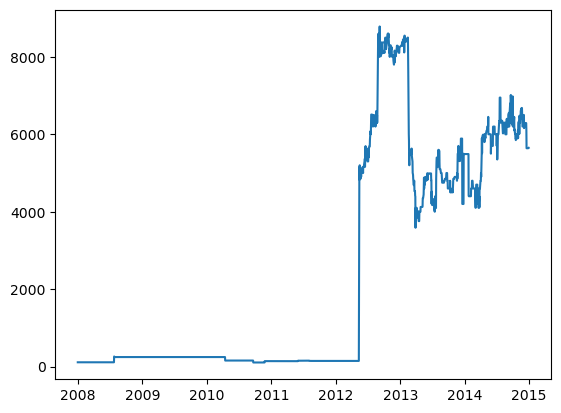

In [15]:
import matplotlib.pyplot as plt
plt.plot(oil_to_day["date"], oil_to_day["price"])

In [14]:
oil_to_months = mean_of_month(oil_to_day)
oil_to_months

/tmp/ipykernel_11060/73500290.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_months = date_to_months.mean()


,date,price
0,2008-01,110.000000
1,2008-02,110.000000
2,2008-03,110.000000
3,2008-04,110.000000
4,2008-05,110.000000
...,...,...
79,2014-08,6177.380952
80,2014-09,6498.636364
81,2014-10,6072.391304
82,2014-11,6413.888889


In [15]:
oil_to_year = mean_of_year(oil_to_day)
oil_to_year

/tmp/ipykernel_11060/4118540001.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_year = date_to_year.mean()


,date,price
0,2008,168.797710
1,2009,245.000000
2,2010,168.048780
3,2011,144.155468
4,2012,4656.717673
5,2013,5205.696000
6,2014,5787.157895


## ZCYC USA

In [16]:
year_start = 2008
year_end = 2014

user_agent = UserAgent()
 
headers = {
    "User-Agent": user_agent.random
}

res = requests.get("https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2023", headers=headers)
if res.status_code == 200:
    html = BeautifulSoup(res.text, "lxml")
else:
    print("error")

In [12]:
link = html.find("div", {"class": "csv-feed views-data-export-feed"}).find("a").get("href")

In [13]:
curve_us_datalist = []

for year in range(year_start, year_end + 1):
    response = requests.get(link.replace("2023", str(year)), headers=headers)
    print(response.status_code)
    if response.status_code == 200:
        response = response.text.split("\n")
    else:
        print("error")
        break

 
    list_table = [[*row.split(",")] for row in response[1:]]
 
    df = pd.DataFrame(list_table, columns=response[0].split(","))
    df.columns = df.columns.str.strip('"')
    curve_us_datalist.append(df)

200
200
200
200
200
200
200


In [14]:
	
curve_us_day = pd.concat(curve_us_datalist)
curve_us_day.columns = ["date", "1/12", "0.25", "0.5", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "20.0", "30.0"]
curve_us_day = curve_us_day.replace('', np.nan)
curve_us_day = curve_us_day.dropna()
curve_us_day.reset_index(inplace=True, drop=True)

for col in curve_us_day.columns:
    if(col != "date"):
        curve_us_day[col] = curve_us_day[col].astype(float)
    else:
        curve_us_day[col] = pd.to_datetime(curve_us_day[col])

curve_us_day


,date,1/12,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2008-12-31,0.11,0.11,0.27,0.37,0.76,1.00,1.55,1.87,2.25,3.05,2.69
1,2008-12-30,0.11,0.10,0.26,0.34,0.75,0.94,1.47,1.76,2.11,2.88,2.58
2,2008-12-29,0.04,0.06,0.25,0.36,0.78,0.96,1.45,1.75,2.13,2.94,2.63
3,2008-12-26,0.01,0.03,0.23,0.38,0.89,1.08,1.51,1.80,2.16,2.91,2.61
4,2008-12-23,0.01,0.02,0.26,0.41,0.90,1.13,1.53,1.81,2.18,2.93,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...
1744,2014-01-08,0.00,0.05,0.08,0.13,0.43,0.87,1.77,2.44,3.01,3.67,3.90
1745,2014-01-07,0.01,0.04,0.08,0.13,0.40,0.80,1.69,2.37,2.96,3.64,3.88
1746,2014-01-06,0.01,0.05,0.08,0.12,0.40,0.78,1.70,2.38,2.98,3.66,3.90
1747,2014-01-03,0.02,0.07,0.10,0.13,0.41,0.80,1.73,2.42,3.01,3.69,3.93


In [54]:
curve_us_to_year = mean_of_year(curve_us_day)
curve_us_to_year

/var/folders/f2/0t72_0jx48526fr5cl7zyc3h0000gn/T/ipykernel_9251/4118540001.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_year = date_to_year.mean()


,date,1/12,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2008,1.308669,1.413750,1.677782,1.843589,2.025806,2.256734,2.819637,3.187903,3.680484,4.375444,4.296008
1,2009,0.096360,0.150920,0.282720,0.473520,0.958480,1.430640,2.197800,2.815120,3.264120,4.113080,4.076680
2,2010,0.114542,0.138446,0.196773,0.317649,0.703347,1.107291,1.930159,2.618526,3.215060,4.029482,4.251076
3,2011,0.039600,0.052840,0.095720,0.180880,0.449360,0.746760,1.518240,2.156840,2.781640,3.617560,3.910800
4,2012,0.070760,0.087600,0.133840,0.174840,0.276160,0.382280,0.761720,1.220440,1.803440,2.541800,2.921680
5,2013,0.046280,0.057080,0.088320,0.131160,0.307080,0.542840,1.172080,1.737520,2.350160,3.118280,3.446160
6,2014,0.028200,0.032720,0.064600,0.121120,0.462080,0.897960,1.641600,2.144040,2.539560,3.072640,3.338160


In [55]:
curve_us_to_month = mean_of_month(curve_us_day)
curve_us_to_month

/var/folders/f2/0t72_0jx48526fr5cl7zyc3h0000gn/T/ipykernel_9251/73500290.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_to_months = date_to_months.mean()


,date,1/12,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2008-01,2.738571,2.820000,2.836190,2.711429,2.475714,2.511429,2.980476,3.307143,3.744286,4.350476,4.330476
1,2008-02,2.273000,2.174000,2.098000,2.053500,1.973000,2.188000,2.779000,3.209500,3.737500,4.493000,4.517000
2,2008-03,1.350500,1.283500,1.507000,1.544000,1.617000,1.796500,2.483500,2.932000,3.510000,4.356000,4.393000
3,2008-04,1.071818,1.311818,1.582727,1.738182,2.047273,2.232727,2.841364,3.193636,3.675000,4.437273,4.443182
4,2008-05,1.758571,1.764286,1.863333,2.055714,2.445714,2.689524,3.153333,3.460000,3.880000,4.595238,4.596190
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2014-08,0.030000,0.032857,0.052381,0.107143,0.472381,0.927619,1.631429,2.080476,2.420000,2.936667,3.200952
80,2014-09,0.011429,0.020000,0.043810,0.109524,0.566667,1.050952,1.773810,2.220476,2.534286,3.013333,3.260000
81,2014-10,0.020909,0.016818,0.050455,0.104545,0.445455,0.875000,1.545909,1.980455,2.304091,2.773182,3.040000
82,2014-11,0.041667,0.021667,0.069444,0.134444,0.527222,0.962778,1.620556,2.028889,2.325556,2.764444,3.038333


## Создание основного рабочего датафрейма

In [165]:
main_df = pd.read_csv("RussianCurve.csv")

In [169]:
main_df.head()
main_df['date'] = pd.to_datetime(main_df["date"])

In [167]:
opec_oil = pd.read_csv('QDL-OPEC.csv')
opec_oil["date"] = pd.to_datetime(opec_oil["date"])
opec_oil.drop(opec_oil[(opec_oil['date'] < '2008-01-9') | (opec_oil['date'] > '2014-12-30')].index, inplace=True)

In [173]:
main_df = main_df.merge(opec_oil)

In [174]:
main_df.head()

,Unnamed: 0,date,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0,value
0,0,2014-12-30,12.74,13.10,13.50,13.90,15.14,15.51,15.13,14.31,13.15,11.83,11.04,10.23,52.39
1,1,2014-12-29,13.57,13.63,13.79,14.04,15.16,15.55,15.20,14.38,13.20,11.85,11.04,10.20,54.44
2,2,2014-12-26,14.47,14.52,14.57,14.64,14.99,15.20,14.88,14.12,13.01,11.77,11.02,10.19,56.14
3,4,2014-12-24,15.45,15.53,15.56,15.56,15.45,15.38,14.98,14.27,13.09,11.81,11.10,10.38,56.03
4,5,2014-12-23,15.28,15.34,15.37,15.39,15.44,15.36,14.76,13.91,12.69,11.47,10.84,10.23,55.59


In [175]:
main_df.to_csv("main_df.csv")